In [1]:
%matplotlib inline

from datetime import datetime

# Force GeoPandas pre version 0.14 to use Shapely by default instead of PyGEOS
import os
os.environ['USE_PYGEOS'] = '0'

import sys

import geopandas as gp
import fiona
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon

from scipy.spatial import cKDTree

import networkx as nx

import osmnx as ox

#ox.settings.use_cache = True
from adjustText import adjust_text
%matplotlib inline

In [2]:
data_loc = "../DATA/"

In [3]:
def make_gdf(data_df):
    """
    Creates a GeoDataFrame from a given DataFrame containing spatial data.

    Args:
        data_df (pandas.DataFrame): A DataFrame containing data, which may include a 'geometry' column.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame with the following properties:
            - If 'geometry' column exists in `data_df`, it converts the geometries from Well-Known Text (WKT) format
              to GeoPandas geometries and sets the coordinate reference system (CRS) to EPSG:4326 (WGS 84).
            - If 'geometry' column does not exist, it assumes the data contains columns 'longitude' and 'latitude'
              and creates a GeoDataFrame with Point geometries based on these coordinates.

    Example:
        Suppose `data_df` contains information about locations (e.g., latitude, longitude, and other attributes).
        The function can be used to create a GeoDataFrame for spatial analysis.

    Note:
        - If the input DataFrame already has a 'geometry' column, it should contain geometries in WKT format.
        - If the input DataFrame does not have a 'geometry' column, it must have 'longitude' and 'latitude' columns.
        - The returned GeoDataFrame will include the original data columns from `data_df`.

    References:
        - GeoPandas documentation:
          https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html
    """
    if 'geometry' in data_df.columns:
        data_df['geometry'] = data_df['geometry'].apply(wkt.loads)
        return gp.GeoDataFrame(data_df, crs='epsg:4326')
    else:
        data_df.columns = data_df.columns.str.lower()
        geo_df = gp.GeoDataFrame(
            data_df, crs=4326, geometry=gp.points_from_xy(data_df.longitude, data_df.latitude))
        return geo_df


In [4]:
BDC_Cable_gdf = make_gdf(pd.read_csv(data_loc + 'EUP_BDC_cable_fixed_jul23mar24.csv'))
BDC_Fiber_gdf = make_gdf(pd.read_csv(data_loc + 'EUP_BDC_fiber_fixed_jul23mar24.csv'))
BDC_Copper_gdf = make_gdf(pd.read_csv(data_loc + 'EUP_BDC_copper_fixed_jul23mar24.csv'))
USAC_Deployment_gdf = make_gdf(pd.read_csv(data_loc + 'EUP_USAC_Deployment-0923.csv'))
EUP_BSL_gdf = make_gdf(pd.read_csv(data_loc + 'EUP_BSL.csv'))

In [5]:
BDC_Cable_gdf = BDC_Cable_gdf[['unit_count', 'bsl_flag', 'building_type_code', 
                               'land_use_code', 'h3_9', 'fcc_rel', 'frn', 'provider_id', 'brand_name',
                               'technology', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]
BDC_Cable_gdf['technology_name'] = 'Cable'

In [6]:
BDC_Fiber_gdf = BDC_Fiber_gdf[['unit_count', 'bsl_flag', 'building_type_code', 
                               'land_use_code', 'h3_9', 'fcc_rel', 'frn', 'provider_id', 'brand_name',
                               'technology', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]

BDC_Fiber_gdf['technology_name'] = 'Fiber'

In [7]:
BDC_Copper_gdf = BDC_Copper_gdf[['unit_count', 'bsl_flag', 'building_type_code', 
                               'land_use_code', 'h3_9', 'fcc_rel', 'frn', 'provider_id', 'brand_name',
                               'technology', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'geometry']]
BDC_Copper_gdf['technology_name'] = 'DSL'

In [8]:
BDC_Cable_gdf.columns

Index(['unit_count', 'bsl_flag', 'building_type_code', 'land_use_code', 'h3_9',
       'fcc_rel', 'frn', 'provider_id', 'brand_name', 'technology',
       'max_advertised_download_speed', 'max_advertised_upload_speed',
       'low_latency', 'business_residential_code', 'geometry',
       'technology_name'],
      dtype='object')

In [9]:
BDC_Fiber_gdf.columns

Index(['unit_count', 'bsl_flag', 'building_type_code', 'land_use_code', 'h3_9',
       'fcc_rel', 'frn', 'provider_id', 'brand_name', 'technology',
       'max_advertised_download_speed', 'max_advertised_upload_speed',
       'low_latency', 'business_residential_code', 'geometry',
       'technology_name'],
      dtype='object')

In [10]:
BDC_Copper_gdf['low_latency'] = 0

In [11]:
USAC_Deployment_gdf['Download/Upload Speed Tier'].unique()

array(['10 Mbps/1 Mbps', '100 Mbps/25 Mbps', '25 Mbps/3 Mbps',
       '4 Mbps/1 Mbps', '1 Gbps/500 Mbps'], dtype=object)

In [12]:
USAC_Deployment_gdf.columns

Index(['Unnamed: 0', 'Fund', 'Study Area Code', 'Company Name', 'Carrier',
       'Latitude', 'Longitude', 'Deployment Address', 'Deployment City',
       'Deployment State', 'Deployment ZIP Code', 'SAC Primary State',
       'Deployment Date', 'Filing Year', 'Census Block', 'Locations Deployed',
       'Download/Upload Speed Tier', 'Technology', 'Other Technology',
       'Latency', 'Overlapping Locations', 'FIPSCODE', 'geometry'],
      dtype='object')

In [13]:
BDC_fixed_gdf = pd.concat([BDC_Cable_gdf, BDC_Fiber_gdf, BDC_Copper_gdf], ignore_index=True)
BDC_fixed_gdf = BDC_fixed_gdf[['building_type_code', 'land_use_code', 'provider_id', 'brand_name',
                               'technology', 'technology_name', 'max_advertised_download_speed', 'max_advertised_upload_speed',
                               'low_latency', 'business_residential_code', 'h3_9', 'geometry']]

In [14]:
BDC_fixed_gdf['up_down_ratio'] = BDC_fixed_gdf['max_advertised_upload_speed'] / BDC_fixed_gdf['max_advertised_download_speed']

In [15]:
BDC_fixed_gdf.to_file(data_loc + 'BDC_fixed.gpkg', driver="GPKG", index=False)

In [16]:
BDC_fixed_gdf = gp.read_file(data_loc + 'BDC_fixed.gpkg')

In [17]:
BDC_fixed_gdf.columns

Index(['building_type_code', 'land_use_code', 'provider_id', 'brand_name',
       'technology', 'technology_name', 'max_advertised_download_speed',
       'max_advertised_upload_speed', 'low_latency',
       'business_residential_code', 'h3_9', 'up_down_ratio', 'geometry'],
      dtype='object')

In [18]:
fiona.listlayers(data_loc + 'EUPOSMgraph.gpkg')

['nodes', 'edges']

In [19]:
EUP_Roads_gdf = gp.read_file(data_loc + 'EUPOSMgraph.gpkg', layer='edges')

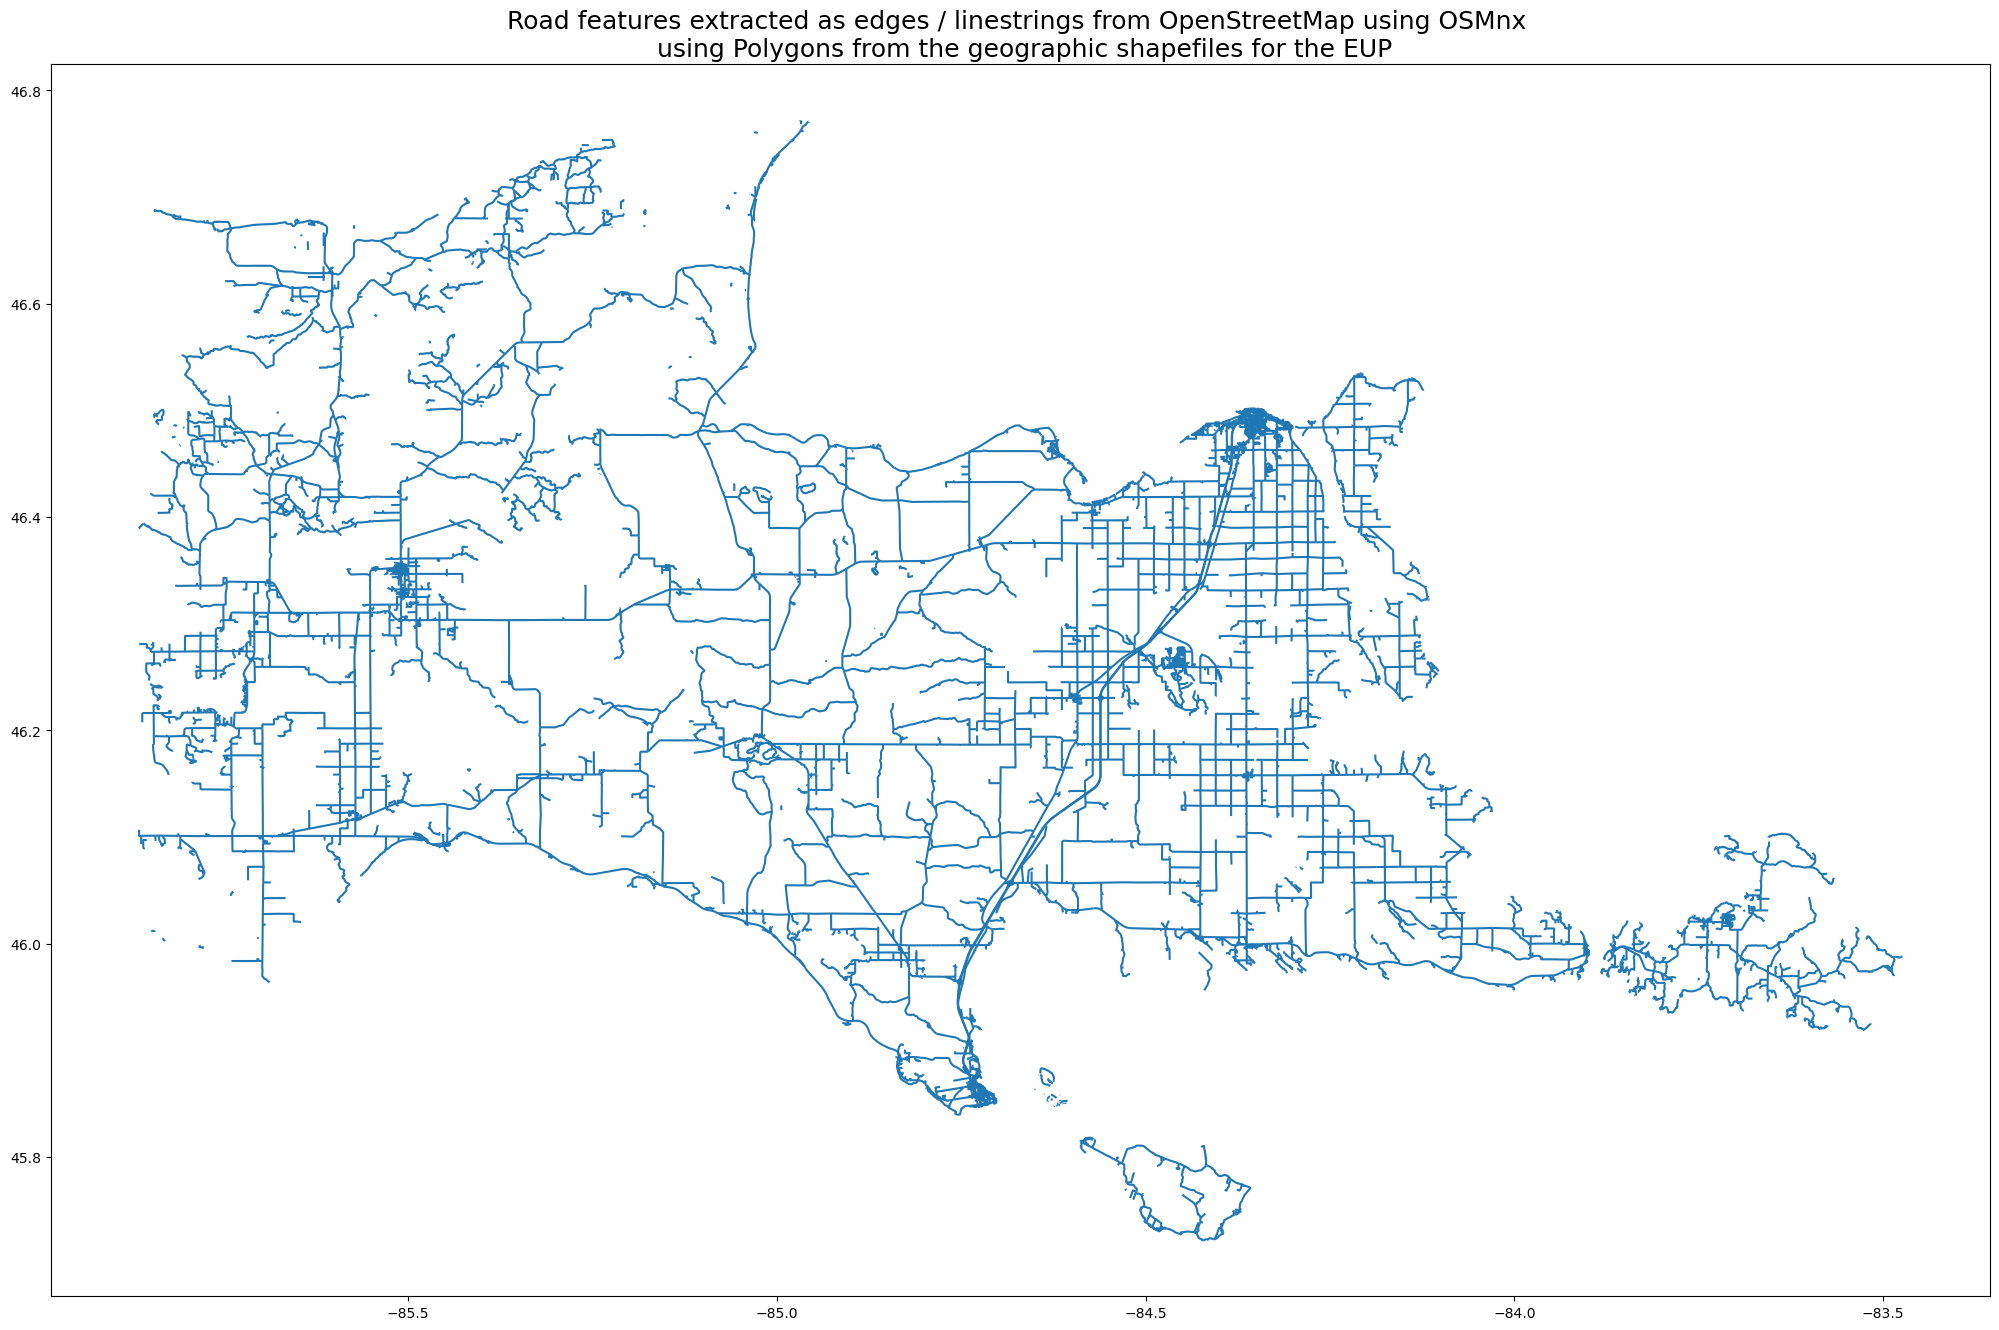

In [20]:
fig, ax = plt.subplots(figsize=(32,16))
EUP_Roads_gdf.plot(ax=ax)

plt.title('''Road features extracted as edges / linestrings from OpenStreetMap using OSMnx \n using Polygons from the geographic shapefiles for the EUP''', fontsize=18)

plt.show()

R: Residential
B: Business
X: Mixed Use (Residential and Business)
G: Group Quarters


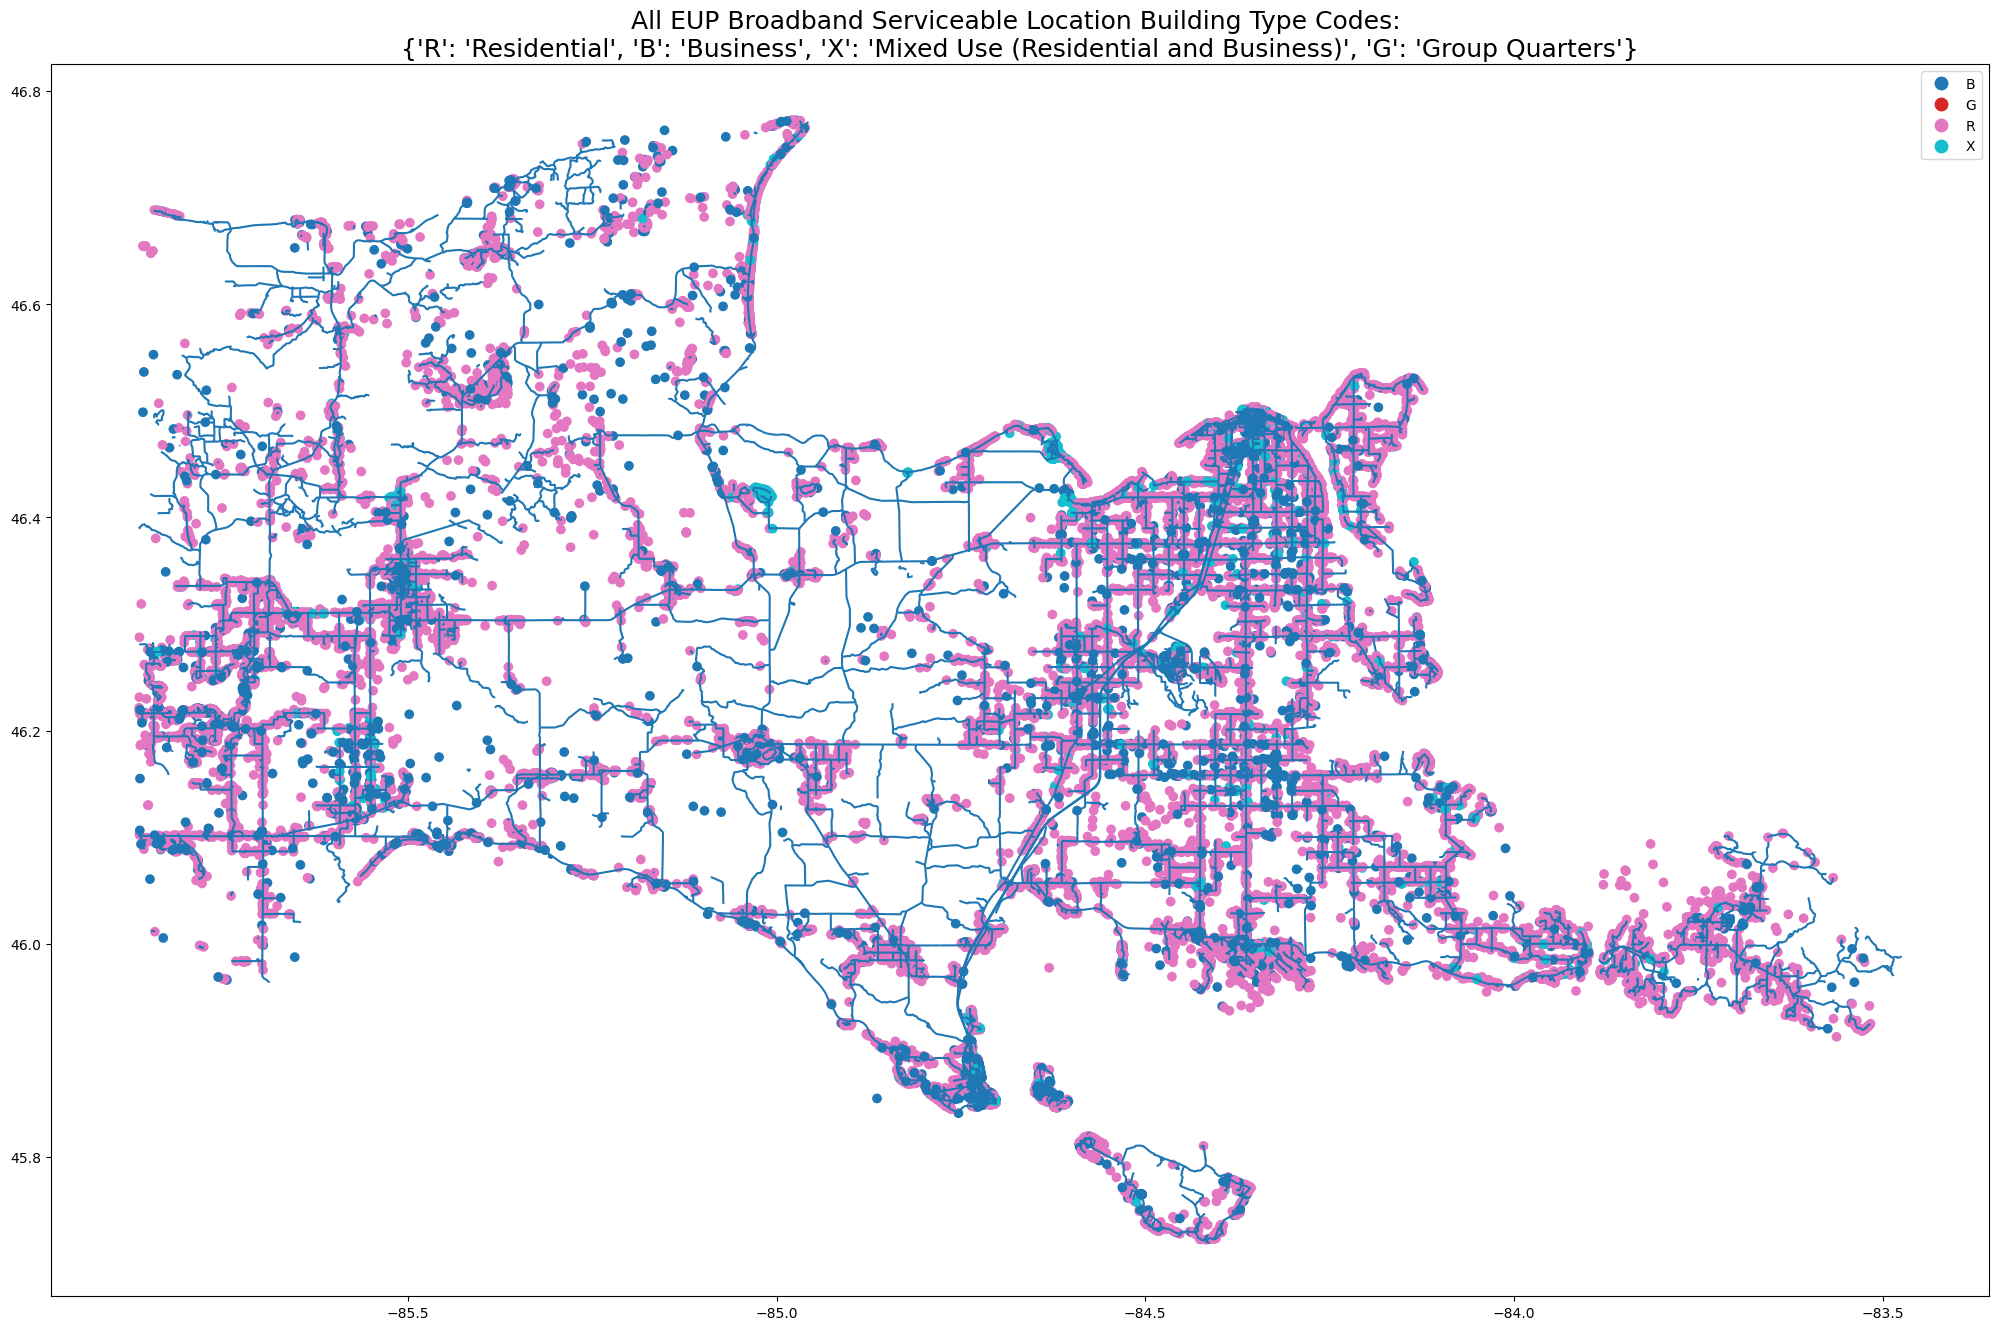

In [21]:
building_type_codes = {
    'R': 'Residential',
    'B': 'Business',
    'X': 'Mixed Use (Residential and Business)',
    'G': 'Group Quarters'
}

for code, description in building_type_codes.items():
    print(f"{code}: {description}")

fig, ax = plt.subplots(figsize=(32,16))

EUP_BSL_gdf.plot(ax=ax, column='building_type_code', legend=True)

EUP_Roads_gdf.plot(ax=ax)

plt.title('All EUP Broadband Serviceable Location Building Type Codes: \n' + str(building_type_codes), fontsize=18)

plt.show()

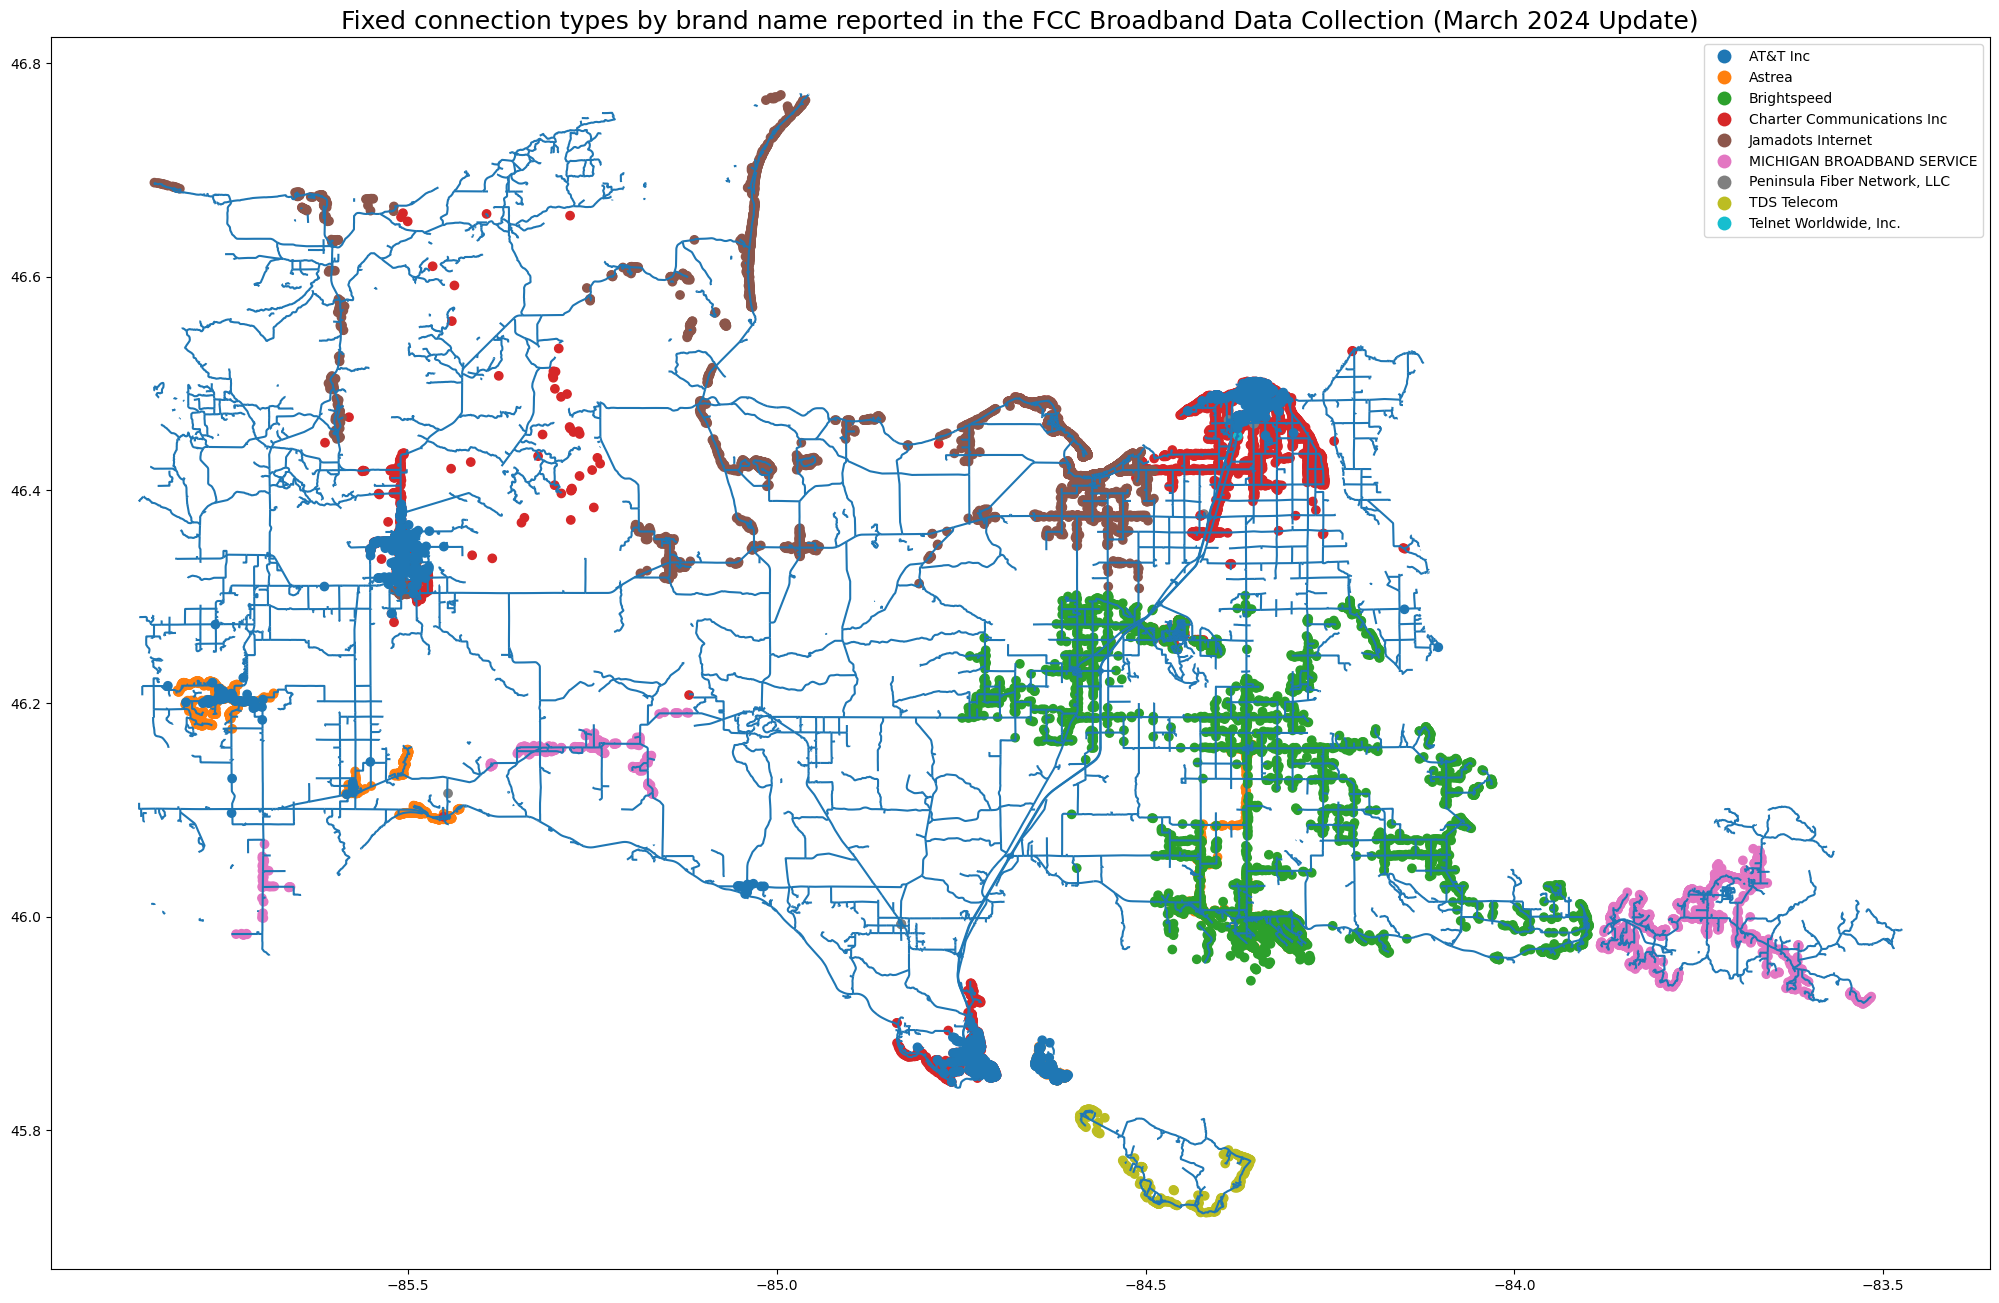

In [22]:
fig, ax = plt.subplots(figsize=(32,16))

BDC_fixed_gdf.plot(ax=ax, column='brand_name', legend=True)

EUP_Roads_gdf.plot(ax=ax)

plt.title('''Fixed connection types by brand name reported in the FCC Broadband Data Collection (March 2024 Update)''', fontsize=18)

plt.show()

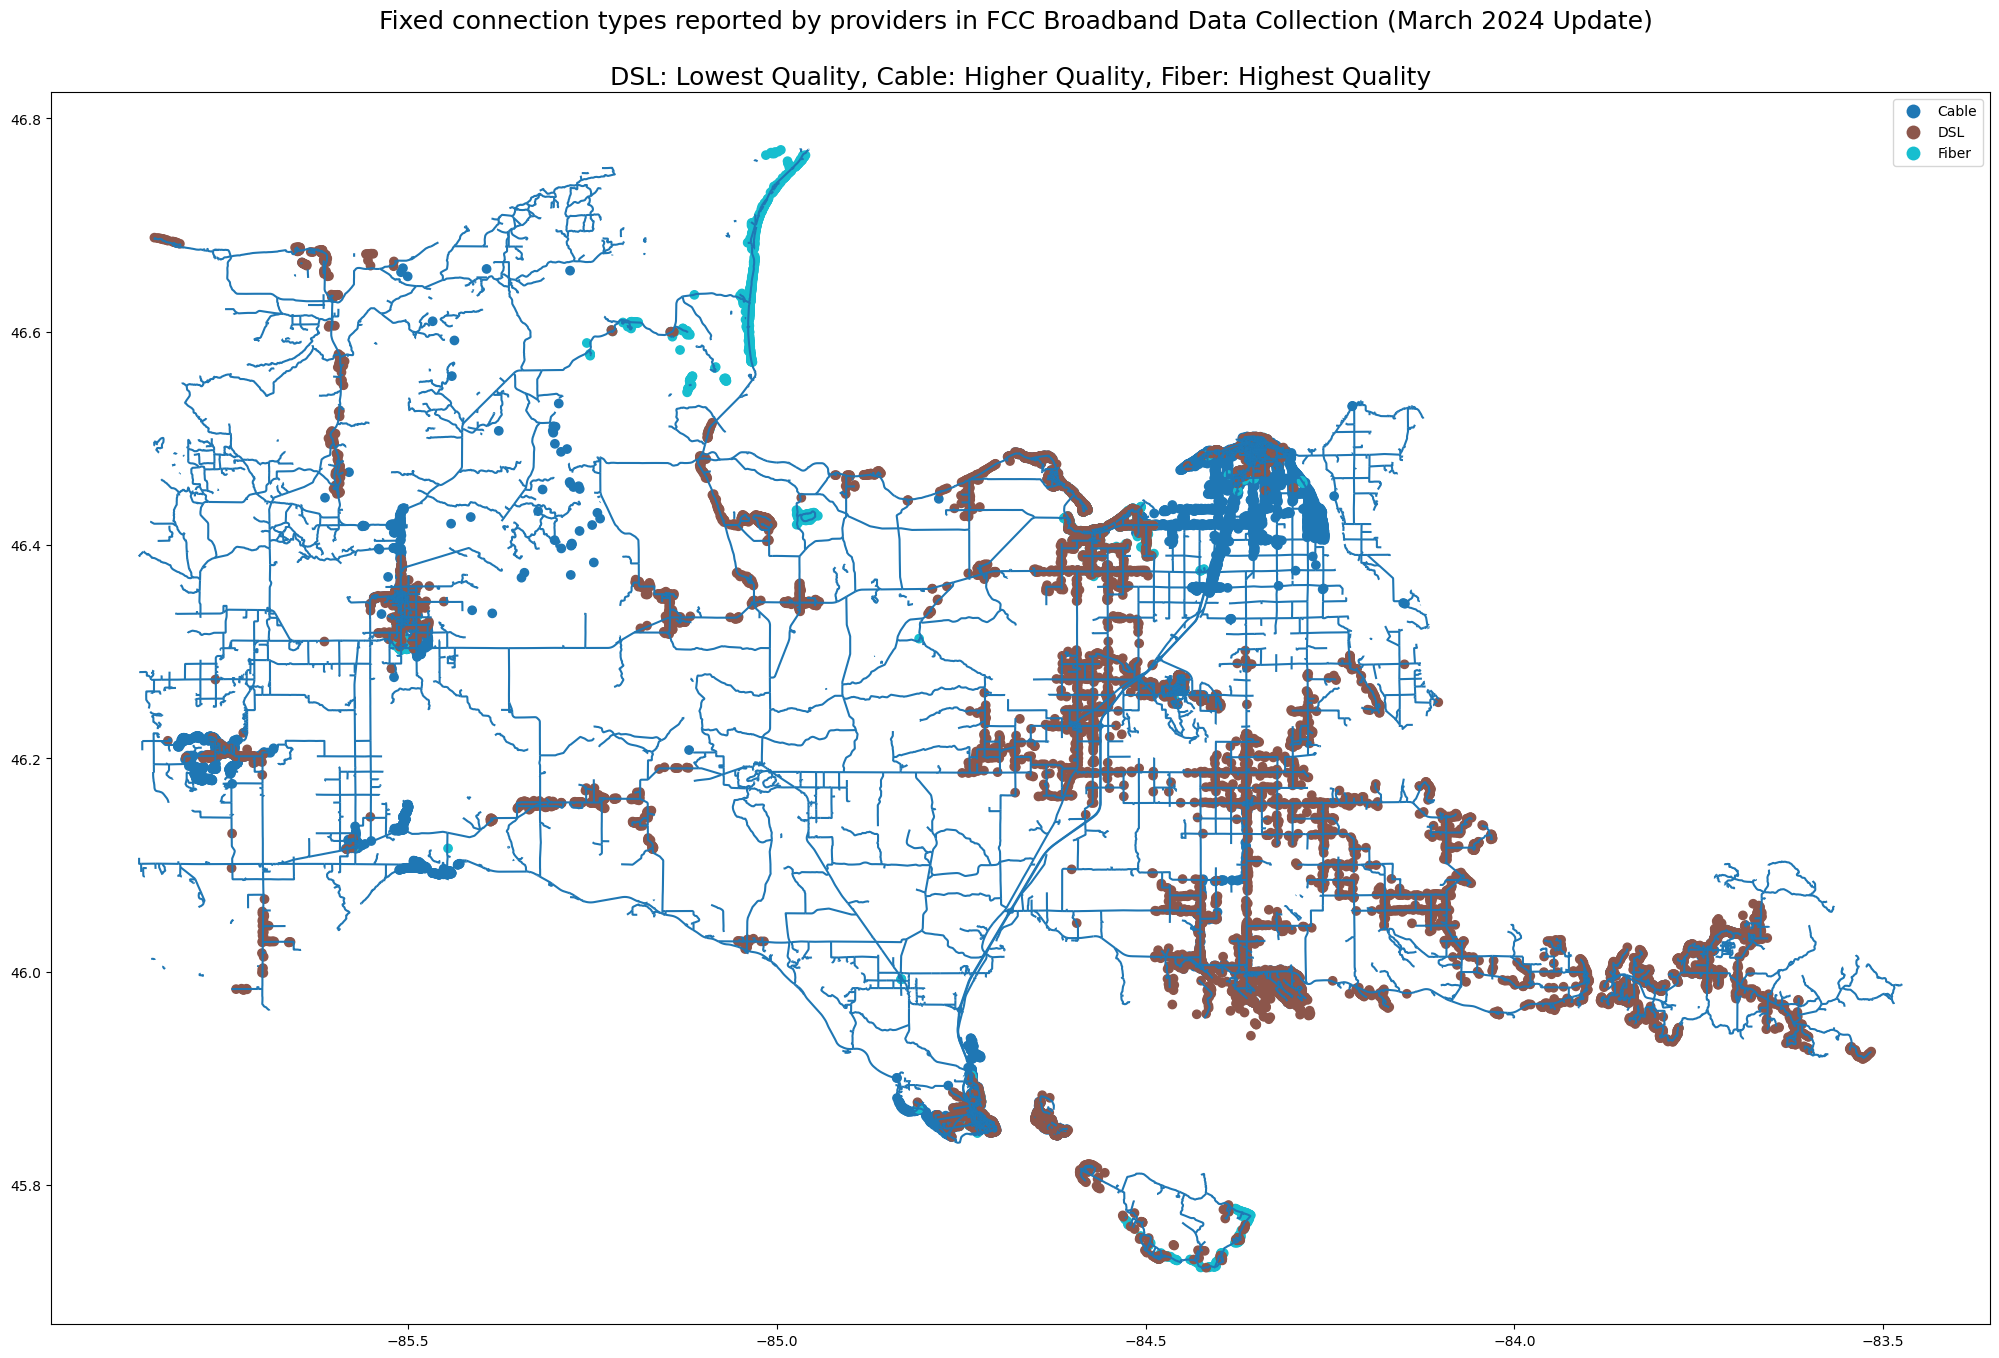

In [23]:
fig, ax = plt.subplots(figsize=(32,16))

BDC_fixed_gdf.plot(ax=ax, column='technology_name', legend=True)

EUP_Roads_gdf.plot(ax=ax)

plt.title('''Fixed connection types reported by providers in FCC Broadband Data Collection (March 2024 Update) \n
DSL: Lowest Quality, Cable: Higher Quality, Fiber: Highest Quality''', fontsize=18)

plt.show()


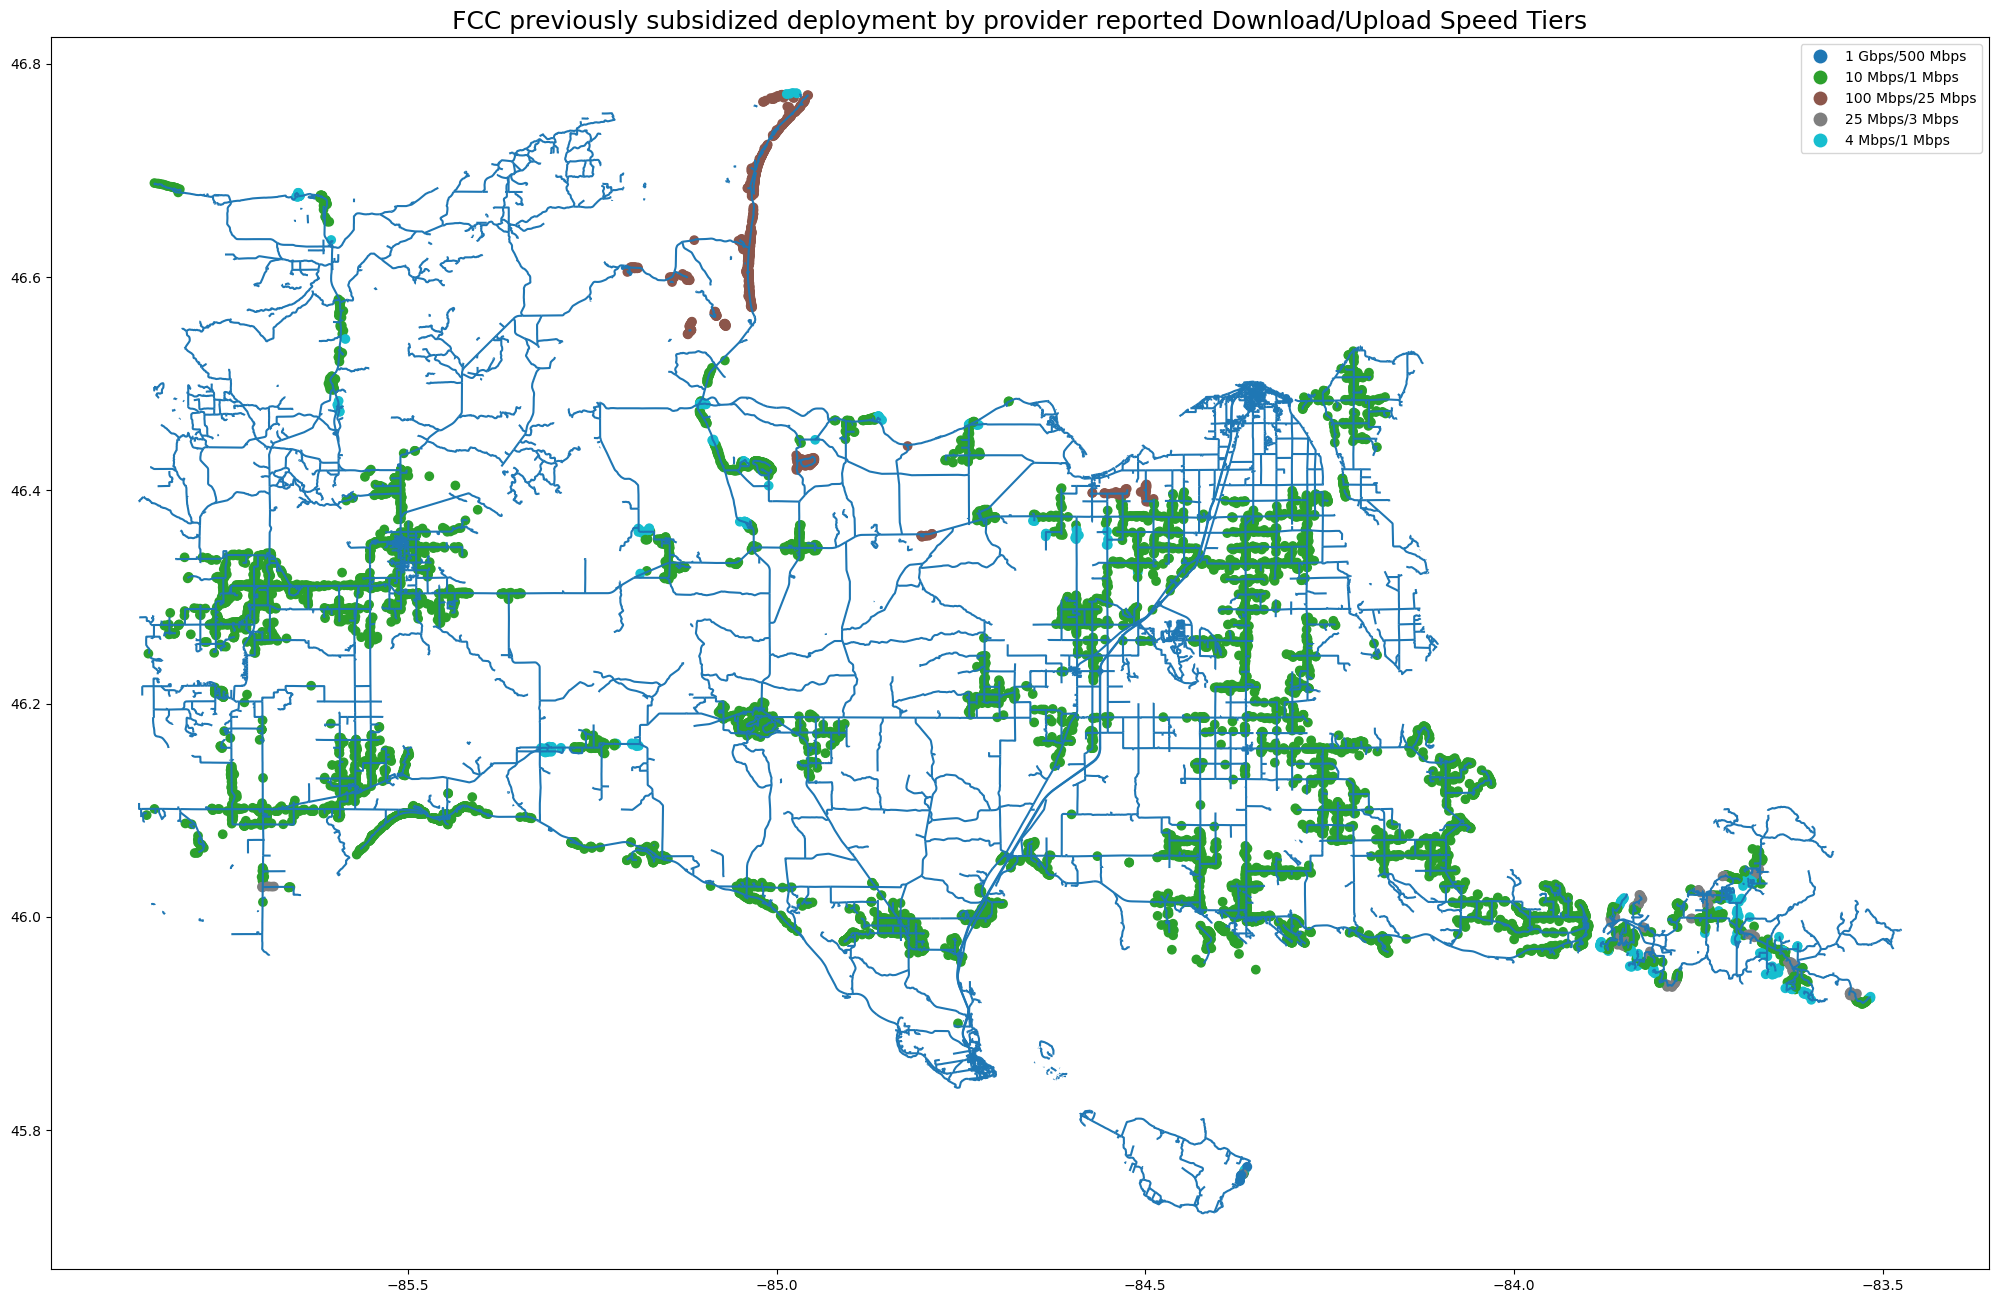

In [24]:
fig, ax = plt.subplots(figsize=(32,16))

USAC_Deployment_gdf.plot(ax=ax, column='Download/Upload Speed Tier', legend=True)

EUP_Roads_gdf.plot(ax=ax)

plt.title('FCC previously subsidized deployment by provider reported Download/Upload Speed Tiers', fontsize=18)

plt.show()

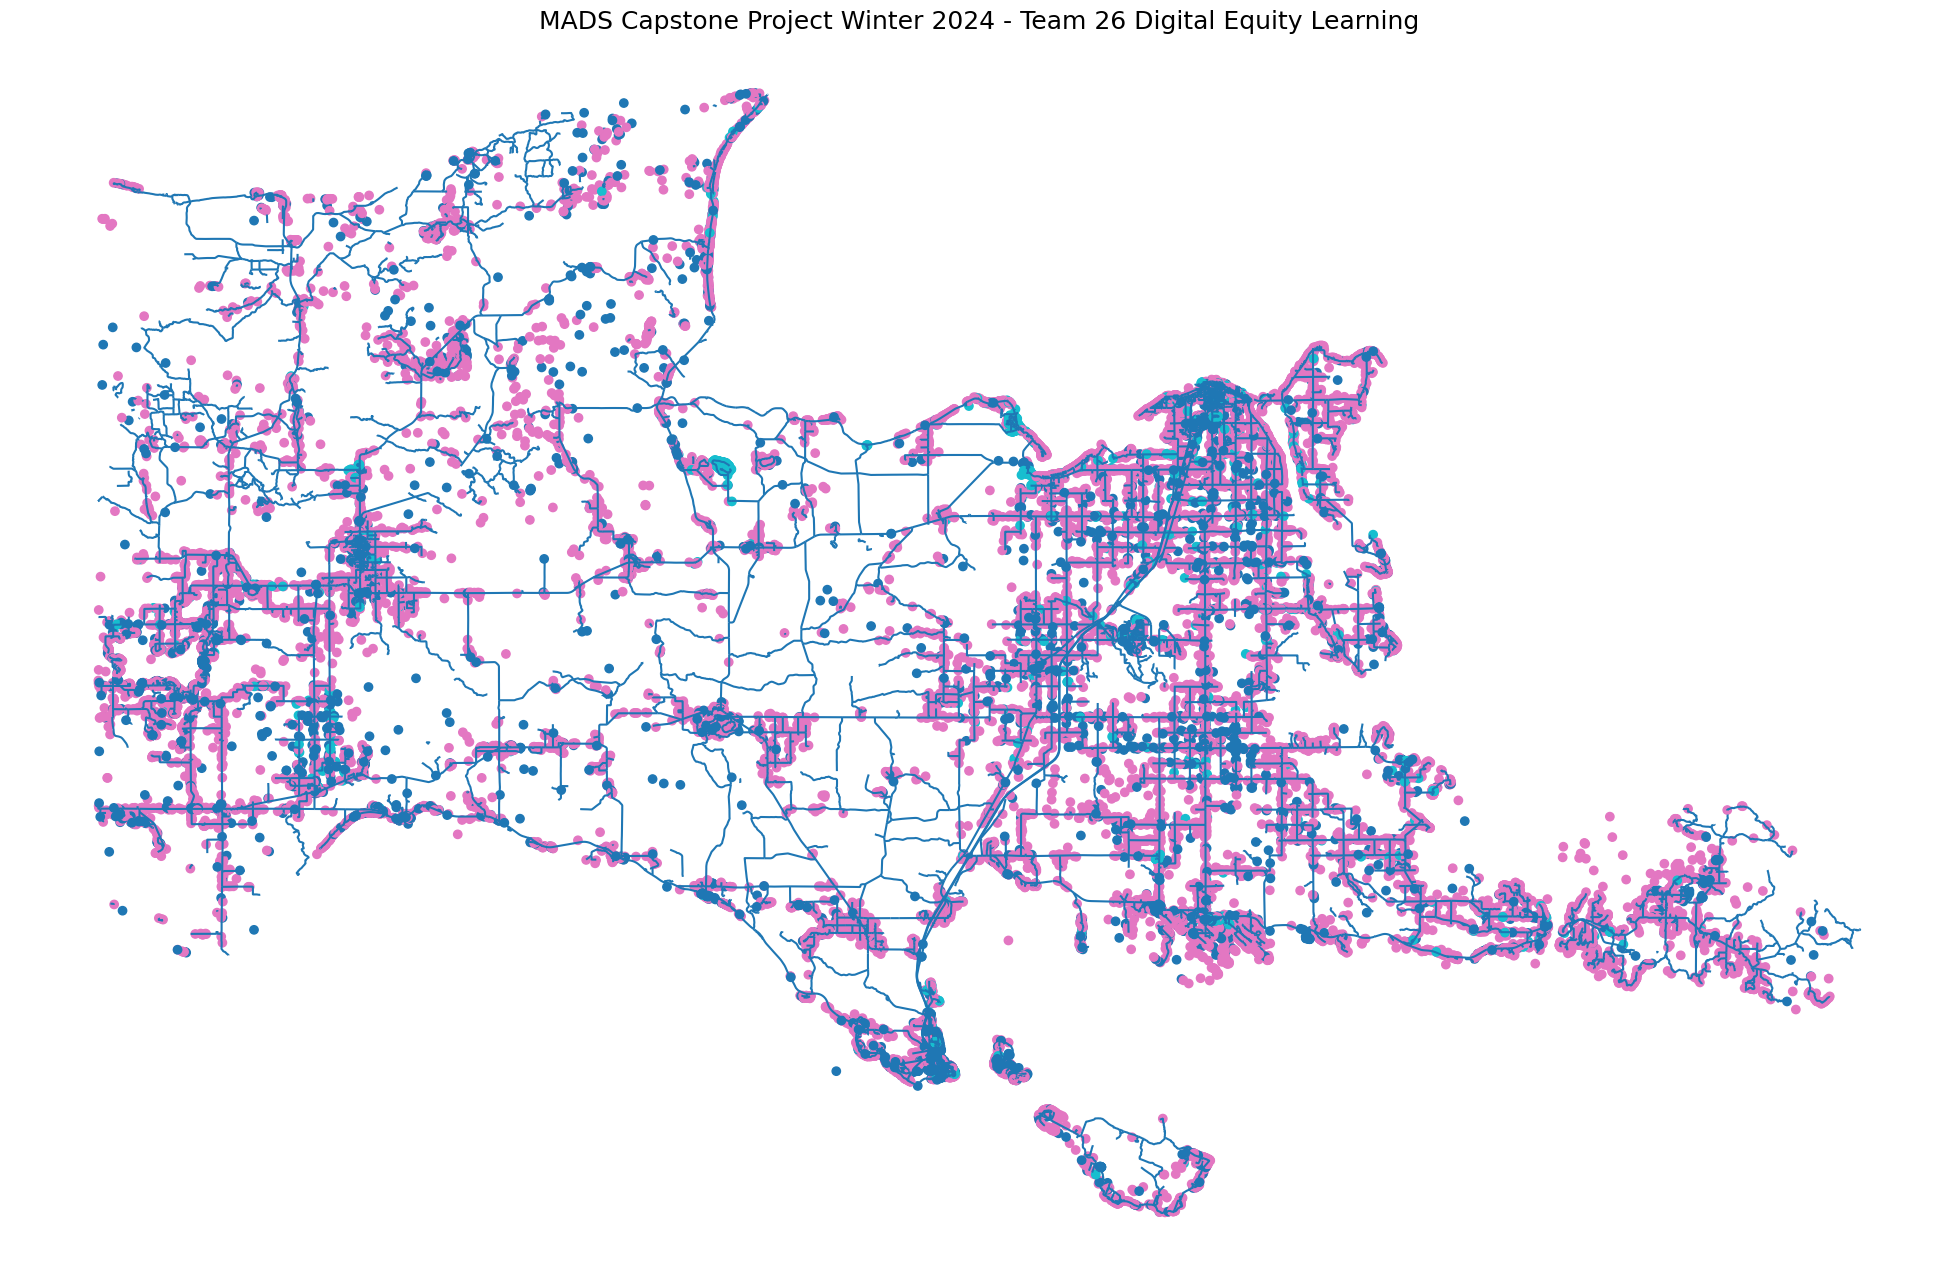

In [29]:
fig, ax = plt.subplots(figsize=(32,16))

EUP_BSL_gdf.plot(ax=ax, column='building_type_code', legend=False)

EUP_Roads_gdf.plot(ax=ax)
ax.set_axis_off()
plt.title('MADS Capstone Project Winter 2024 - Team 26 Digital Equity Learning', fontsize=18)

plt.show()

In [25]:
technology_codes = {
    "Copper Wire (Code 10)": "Fixed wireline service using copper wire, including technologies like Asymmetric or Symmetric DSL, Ethernet over copper, and T-1.",
    "Coaxial Cable / HFC (Code 40)": "Fixed wireline service using coaxial cable or hybrid fiber-coaxial (e.g., DOCSISx).",
    "Optical Carrier / Fiber to the Premises (Code 50)": "Fixed wireline service using fiber-optic cables to connect to homes or business end users. However, it does not include \"fiber to the curb\".",
    "Geostationary Satellite (Code 60)": "Fixed non-terrestrial wireless service using satellites in geostationary orbit (i.e., Geostationary Earth Orbit).",
    "Non-geostationary Satellite (Code 61)": "Fixed non-terrestrial wireless service using satellites in non-geostationary orbit (i.e., Low Earth Orbit or Medium Earth Orbit).",
    "Unlicensed Terrestrial Fixed Wireless (Code 70)": "Fixed terrestrial wireless service using entirely unlicensed spectrum, including services provided over WiFi as a fixed solution.",
    "Licensed Terrestrial Fixed Wireless (Code 71)": "Fixed terrestrial wireless service using entirely licensed spectrum (including priority access licenses in the 3.5 GHz band) or a hybrid of licensed, unlicensed, and licensed-by-rule spectrum for last-mile connections to fixed locations. This includes service provided over a 4G LTE or 5G-NR mobile network but sold as a fixed solution. Providers that use licensed microwave spectrum for backhaul but otherwise use unlicensed or licensed-by-rule spectrum for last-mile connections to end users may not use this technology code.",
    "Licensed-by-Rule Terrestrial Fixed Wireless (Code 72)": "Fixed terrestrial wireless services using entirely licensed-by-rule spectrum or a hybrid of licensed-by-rule and unlicensed spectrum for last-mile connections to fixed locations. Licensed-by-rule spectrum users include operators providing last-mile connections through general authorized access (GAA) in the 3.5 GHz Citizens Broadband Radio Service (CBRS) band.",
    "Other": "Other fixed service using any technology not otherwise detailed for another code."
}

for code, description in technology_codes.items():
    print(f"{code}: {description}\n")

Copper Wire (Code 10): Fixed wireline service using copper wire, including technologies like Asymmetric or Symmetric DSL, Ethernet over copper, and T-1.

Coaxial Cable / HFC (Code 40): Fixed wireline service using coaxial cable or hybrid fiber-coaxial (e.g., DOCSISx).

Optical Carrier / Fiber to the Premises (Code 50): Fixed wireline service using fiber-optic cables to connect to homes or business end users. However, it does not include "fiber to the curb".

Geostationary Satellite (Code 60): Fixed non-terrestrial wireless service using satellites in geostationary orbit (i.e., Geostationary Earth Orbit).

Non-geostationary Satellite (Code 61): Fixed non-terrestrial wireless service using satellites in non-geostationary orbit (i.e., Low Earth Orbit or Medium Earth Orbit).

Unlicensed Terrestrial Fixed Wireless (Code 70): Fixed terrestrial wireless service using entirely unlicensed spectrum, including services provided over WiFi as a fixed solution.

Licensed Terrestrial Fixed Wireless (